## Lesson 2 
in this class we'll learn how to exploit the `random` functionalities of python to handle distributions. Most of the functions will be in the module `np.random` https://numpy.org/doc/2.1/reference/random/index.html  


- uniform distribution : np.random.uniform 
- normal     "         : np.random.normal 
- Poisson     "        : np.random.poisson 


In [1]:
import numpy as np
import pylab as pl 
from scipy.optimize import curve_fit
from scipy.integrate import quad

from scipy.interpolate import interp1d 

from lab3_utils import red_chi_squared, gaussian 

### Uniform distributions 

### Exercise 
- plot a normalized histogram of the distribution with 100 bins 
-   Generate different distributions with different choices of the `size` parameters 
-   plot the histograms into a single plot 


In [2]:
v =np.random.uniform( low=-1,high =1 ,  size= 4000  )

### Your code here ... 

### Non-uniform distributions 

### Exercise on Normal distr.  
 - plot a normalized histogram of the distribution with 100 bins 
 -  fit a gaussian function over the distribution (hint use the lesson_0 notebook to refresh your memory  ;-D ) 
 -  estimate the $\chi^2$ to assess the quality of the fit  

In [3]:
v =np.random.normal( loc=-1,scale  =1 ,  size= 4000  )

### Your code here ... 

### Exercise on Poisson distr. 
  
 -   Generate different distributions with different choices of the `lam` parameter, 
 -   plot the histograms into a single plot 
 -   discuss how the distribution change.   

In [4]:
v =np.random.poisson(lam=3 , size= 400  )
### Your code here ... 

## Sample from any distribution
#### Rejection Sampling 

0. Sample a point described by the random variable $x$  from the proposal probability distribution function (PDF), $P(x)  $ .
1. Draw a vertical line at this x‑position, up to the $P(x)$-value  of the proposal distribution.
2. Sample a y-value uniformly along this line from 0 to $P(x)$. 
3.   If $y>P(x) $ **reject** x and go back  to step 0; 
    else **accept**  x 

Let's assume a sine weighted distribution 

In [71]:
def rejection( n ):
    accepted = 0
    rejected = 0
    total =0
    accepted_x = []
    while accepted < n:
        total+=1 
        ux = np.random.uniform(0, np.pi)
        uy = np.random.uniform(0, 1)
        if uy > np.sin(ux):
            rejected += 1
            continue
        accepted += 1
        accepted_x.append(ux)
    return accepted_x,accepted, rejected , total 
 
N = int(1e5)   

accepted_x,accepted, rejected , total= rejection (N) 
print(total )




157232


... or in a more _pythonic_ way (avoiding the while loop ....) 

In [72]:
xvals = np.random.uniform(0, np.pi, N)   
PDFvals    = np.sin(xvals)   
yvals = np.random.uniform(0,1, N) 

mask_rejected = yvals  > PDFvals  
rejected = xvals[mask_rejected ].size
accepted = xvals[np.logical_not(mask_rejected)  ].size 
accepted_x = xvals[~ mask_rejected ]




Red chi2 :0.810
Rejection fraction = 0.3630
Theoretical rejection = 0.3634
Fit parameter A = 1000.5417


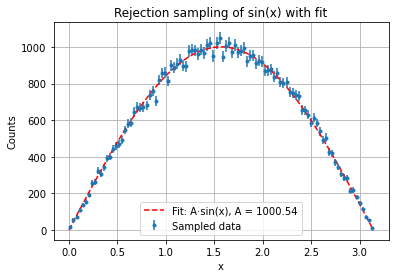

In [73]:
sin_func= lambda x, A: A * np.sin(x)
# Costruiamo l'istogramma per il fit
counts, bin_edges = np.histogram(accepted_x, bins=100, range=(0, np.pi), density=False )
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    # Fit con A * sin(x)
popt, pcov = curve_fit(sin_func, bin_centers, counts)
A_fit = popt[0]

pl.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label='Sampled data', markersize=3)
x_fit = np.linspace(0, np.pi, 500)
y_fit = sin_func(x_fit, A_fit)
pl.plot(x_fit, y_fit, 'r--', label=f'Fit: A·sin(x), A = {A_fit:.2f}')
pl.title("Rejection sampling of sin(x) with fit")
pl.xlabel("x")
pl.ylabel("Counts")
pl.grid(True)
pl.legend()
# Risultati
rejection_fraction = rejected / N
theoretical = (np.pi - 2) / np.pi
print(f"Red chi2 :{red_chi_squared(y_exp=counts , y_obs = sin_func(bin_centers, A_fit), n_params=1, errors=np.sqrt(counts) ):.3f}")

print(f"Rejection fraction = {rejection_fraction:.4f}")
print(f"Theoretical rejection = {theoretical:.4f}")
print(f"Fit parameter A = {A_fit:.4f}")


####  Inverse Sampling  
Also this algorithm warks with **any** . We choose to generate samples from a _power law_ $$f(x)  \propto x^{\alpha} $$ as  this distribution  very useful in several physical contexts: e.g. energy distribution of cosmic rays, the number counts of radio-galaxies in the universe,the initial mass function of stars,  etc...
-  be $x$ a variable distributed with a certain PDF $P(x) \propto x^{\alpha}$  and with Cumulative Distribution Function (CDF)  $C (x>t)= \int_0 ^x P(t)dt  $ 
- Generate a uniform random number $u$ in the interval [0,1] 
- Find the generalized inverse of the desired CDF, i.e. $CDF^{-1}(u) $ 
- Compute a random variable  $\tilde{x}= CDF^{-1}(u) $ that is distributed as $x$


#####  Observations
1. In order to be any function $f$ a PDF $ P(x)  $, we have to make sure that it is normalized so that the integral all over the domain is 1  : 
$$ 
P(x) =\frac{f(x)}{\int dx f} 
$$

2. the random variable $x$ could range over a very wide range, encoding several orders of magnitude. Let's consider the following example. Be $x$ a variable ranging from $[10^{-1}, 100] $ . In order to have $x$  uniformly distributed in the range,  it is more convenient to extract random numbers of the indices as uniformly distributed within $[-1,2]$ and then exponentiate them to get $x$. 



PDF integral :1.00
[0.         0.00940948 0.01873043 ... 0.9999988  0.9999994  1.        ]


Text(0, 0.5, 'PDF')

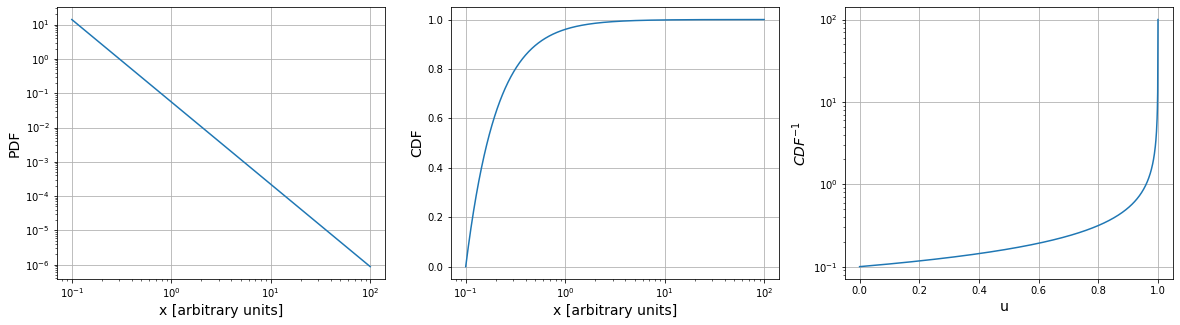

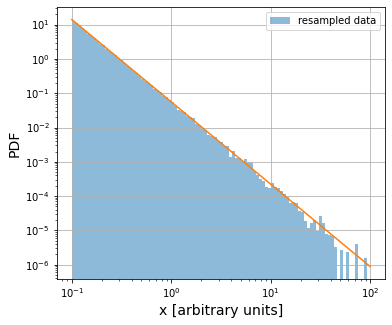

In [98]:
powerlaw= lambda x, A, alpha : A*x**alpha 
alpha = -2.4
ranges=(1e-1, 1e2)
xvals = np.logspace(np.log10(ranges[0]), np.log10(ranges[1] ) ,1024 , endpoint=True )

f= powerlaw(xvals, 1, alpha )
pdf  = f/ np.trapz( f,xvals) 

print(f"PDF integral :{np.trapz(pdf, xvals  ):.2f}")
pl.figure(figsize=(20,5) )
pl.subplot(131)
pl.plot(xvals , pdf )
pl.grid(True)

pl.xlabel('x [arbitrary units]', fontsize= 14)
pl.ylabel('PDF', fontsize= 14)
pl.loglog() 

cdf = np.zeros(xvals.size ) 
for i in range(1,xvals.size+1): 
    cdf[i-1] = np.trapz (pdf[:i]  , xvals[:i] ) 

pl.subplot(132)
pl.plot(xvals , cdf )
pl.xlabel('x [arbitrary units]', fontsize= 14)
pl.ylabel('CDF', fontsize= 14)
pl.semilogx() 
pl.grid(True)
#interpolate inverse of CDF 

interpcdf = interp1d (xvals, cdf, fill_value='extrapolate'  ) 
interpinvcdf = interp1d ( cdf,xvals,kind='linear',  fill_value='extrapolate'  ) 
pl.subplot(133)

pl.plot(np.linspace(0,1,1000) , interpinvcdf (np.linspace(0,1,1000) )) 
pl.semilogy() 
pl.xlabel('u  ', fontsize= 14)
pl.ylabel(r'$CDF^{-1}$', fontsize= 14)
pl.grid(True)

u = np.random.uniform(0,1,N )

xrand = interpinvcdf (u )
pl.figure(figsize=(20,5) )

pl.subplot(131)
pl.hist(xrand, bins =np.logspace(np.log10(ranges[0]), np.log10(ranges[1] ) ,100 ), density=True , alpha=.5  ,label='resampled data') 
pl.plot(xvals , pdf,  )

counts, bin_edges= np.histogram(xrand, bins =np.logspace(np.log10(ranges[0]), np.log10(ranges[1] ) ,100 ), density=True   ) 
pl.loglog() 
print( cdf  )
pl.grid(True)
pl.legend() 
pl.xlabel('x [arbitrary units]', fontsize= 14)
pl.ylabel('PDF', fontsize= 14)